In [75]:
import pandas as pd
# pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 500

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

from pymystem3 import Mystem; mystem = Mystem()
from functools import lru_cache


from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

### Ввод данных

In [3]:
data = pd.read_csv('./DATA_MANY_TOPICS.csv')
data.drop('index', 1, inplace=True)
data.drop(data[data.topic == 'football'].sample(25000).index, inplace=True)
data.drop(data[data.topic == 'hockey'].sample(5000).index, inplace=True)
data.drop(data[data.topic == 'business'].sample(18000).index, inplace=True)
data.drop(data[data.topic == 'politics'].sample(11000).index, inplace=True)

In [5]:
data.sample(5)

,text,title,topic,url
75149,"Последняя, четвертая, нитка газопровода «Турец...",Строительство «Турецкого потока» завершат к 20...,companies,https://lenta.ru/news/2015/04/29/tyrezkipotok_...
45379,"Эксперт Aviasales выяснили, что цены на переле...",Aviasales узнали об экономии в 25 процентов на...,companies,https://lenta.ru/news/2016/06/02/pobeda_compet...
113030,"Пользователи Twitter подшутили над DailyMail, ...",В сети посмеялись над «самой красивой парой Ве...,social-networks,https://lenta.ru/news/2016/11/30/best_looking_...
167866,СКА и ЦСКА в матче регулярного чемпионата КХЛ ...,СКА и ЦСКА забросили пять шайб почти за пять м...,hockey,http://www.sport-express.ru/hockey/khl/news/sk...
145888,"""Питтсбург"" в матче регулярного чемпионата НХЛ...","""Питтсбург"" обыграл ""Тампа-Бэй"", Малкин и Крос...",hockey,http://www.sport-express.ru/hockey/nhl/news/pi...


In [6]:
print('Number of news:', len(data))

Number of news: 129028


In [7]:
print('Number of topics:', data.topic.nunique())

Number of topics: 32


In [8]:
data = data[~((data.topic == 'forces') & (data.url.str.contains('https://www.gazeta.ru/')))]

In [9]:
data.topic.value_counts()

politics           11849
business           10022
technologies        7097
football            6993
films               6592
hockey              6400
science             5558
crime               5308
internet            5067
realty              4878
basketball          4480
judiciary           4165
weapons             4120
forces              3993
music               3809
tennis              3571
auto                3453
companies           3316
cosmos              2732
boxing              2512
economics           2426
biathlon            2235
social-networks     2039
cybersport          1835
formula1            1433
animals             1225
books                939
religion             903
theatre              882
skiing               696
volleyball           528
chess                473
Name: topic, dtype: int64

In [10]:
class Pipeline(object):
    def __init__(self, *args):
        self.transformations = args
    def __call__(self, x):
        res = x
        for f in self.transformations:
            res = f(res)
        return res

In [11]:
from nltk.corpus import stopwords
from stop_words import get_stop_words
en_sw = get_stop_words('en')
ru_sw = get_stop_words('ru')
STOP_WORDS = set(en_sw) | set(ru_sw)
STOP_WORDS = STOP_WORDS | set(stopwords.words('russian')) | set(stopwords.words('english'))
STOP_WORDS = STOP_WORDS | set(['лента', 'новость', 'риа', 'тасс',
                               'редакция', 'газета', 'корра', 'daily',
                               'village', 'интерфакс', 'reuters'])

def remove_ria(text):
    prefix = text[:50]
    ria = 'РИА Новости'
    if ria in prefix:
        text = text[text.find(ria)+len(ria)+1:]
    return text

def remove_tass(text):
    prefix = text[:100]
    return text[max(0, prefix.find('/.')+1):]

def get_lower(text):
    return str(text).lower().strip()

def remove_punctuation(text):
    return ''.join([c if c.isalpha() or c in ['-',"'"] else ' ' for c in text])

@lru_cache(maxsize=None)
def get_word_normal_form(word):
    return ''.join(mystem.lemmatize(word)).strip().replace('ё', 'е').strip('-')

def lemmatize_words(text):
    res = []
    for word in text.split():
        norm_form = get_word_normal_form(word)
        if len(norm_form) > 2 and norm_form not in STOP_WORDS:
            res.append(norm_form)
    return ' '.join(res)

In [12]:
TEXT_PIPELINE = Pipeline(remove_tass, remove_ria, get_lower, remove_punctuation, lemmatize_words)

In [13]:
%%time
data.text = data.text.progress_apply(TEXT_PIPELINE)

100%|██████████| 121529/121529 [01:03<00:00, 1920.71it/s]


CPU times: user 45.1 s, sys: 2.3 s, total: 47.4 s
Wall time: 1min 3s


In [14]:
%%time
data.title = data.title.progress_apply(TEXT_PIPELINE)

100%|██████████| 121529/121529 [00:02<00:00, 44015.20it/s]

CPU times: user 2.35 s, sys: 40 ms, total: 2.39 s
Wall time: 2.77 s


In [15]:
vocabulary = defaultdict(int)
for news in data.itertuples():
    for word in news.text.split():
        vocabulary[word] += 1
print('Unique words in dataset:', len(vocabulary))

Unique words in dataset: 213371


In [16]:
n_min_occurance = 2
print('Number of words occured more than %d times: %d' % 
      (n_min_occurance, len(list(filter(lambda x: x[1] >= n_min_occurance, vocabulary.items())))))

Number of words occured more than 2 times: 125989


In [17]:
top_k = 20
print('Top %d most frequent words:' % top_k)
for i, (word, freq) in enumerate(sorted(vocabulary.items(), key=lambda x: -x[1])[:top_k]):
    print(i+1, word, freq)

Top 20 most frequent words:
1 россия 83533
2 сообщать 74797
3 компания 70497
4 свой 59184
5 российский 48540
6 становиться 46744
7 слово 40831
8 заявлять 40441
9 отмечать 37306
10 получать 35469
11 новый 35372
12 сша 33573
13 страна 31924
14 президент 29195
15 ранее 28903
16 данный 27985
17 матч 27479
18 млрд 27385
19 москва 26753
20 работа 26500


In [18]:
data.topic.value_counts(normalize=True)

politics           0.097499
business           0.082466
technologies       0.058398
football           0.057542
films              0.054242
hockey             0.052662
science            0.045734
crime              0.043677
internet           0.041694
realty             0.040139
basketball         0.036864
judiciary          0.034272
weapons            0.033901
forces             0.032856
music              0.031342
tennis             0.029384
auto               0.028413
companies          0.027286
cosmos             0.022480
boxing             0.020670
economics          0.019962
biathlon           0.018391
social-networks    0.016778
cybersport         0.015099
formula1           0.011791
animals            0.010080
books              0.007727
religion           0.007430
theatre            0.007258
skiing             0.005727
volleyball         0.004345
chess              0.003892
Name: topic, dtype: float64

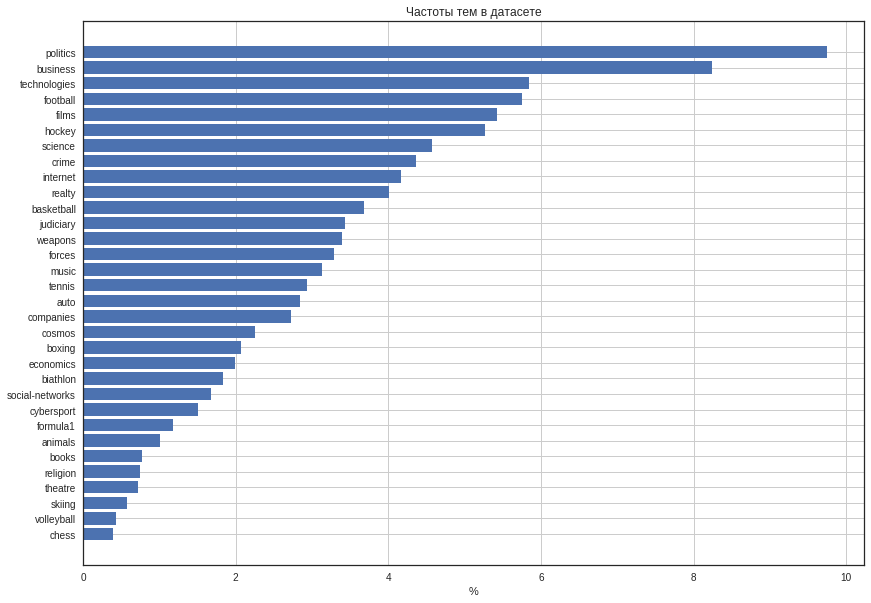

In [19]:
topics_freq = data.topic.value_counts(normalize=True, ascending=True)*100
plt.figure(figsize=(14,10))
plt.barh(range(len(topics_freq)), topics_freq.values)
plt.yticks(range(len(topics_freq)), topics_freq.index);
plt.xticks(np.arange(0, 11, 2));
plt.xlabel('%')
plt.grid(True)
plt.title('Частоты тем в датасете');

# Получим baseline решение с помощью SVM

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.svm import LinearSVC

from scipy.sparse import hstack

### Закодируем целевую переменную

In [21]:
le = LabelEncoder()
data.topic = le.fit_transform(data.topic)

### Разделим данные на train и validation

In [123]:
trainX = pd.concat([pd.DataFrame(data.title + ' ' + data.text, columns=['text']), data.url], axis=1)
trainY = data.topic

In [124]:
trainX.head()

,text,url
1,новак брюссельский договоренность снижать риск...,http://www.vedomosti.ru/business/news/2015/03/...
2,медведев поручать усовершенствовать защита бан...,http://www.vedomosti.ru/economics/news/2015/03...
3,россельхознадзор проинспектировать предприятие...,http://www.vedomosti.ru/economics/news/2015/03...
4,walt disney становиться самый прибыльный компа...,http://www.vedomosti.ru/technology/news/2015/0...
9,новак россия конец март рассматривать вопрос п...,http://www.vedomosti.ru/business/news/2015/03/...


In [40]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.3, stratify=trainY, random_state=42)

### Вычислим tf-idf

In [42]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,2), lowercase=False).fit(trainX.text)
len(tfidf_vectorizer.vocabulary_)

CPU times: user 1min, sys: 380 ms, total: 1min 1s
Wall time: 1min 1s


In [43]:
X_train_tf = tfidf_vectorizer.transform(X_train.text)
X_test_tf = tfidf_vectorizer.transform(X_test.text)

### Обучим SVM

In [44]:
# clf = LinearSVC(C=1, max_iter=10000, loss='hinge', random_state=42)
clf = SGDClassifier(loss='hinge', n_iter=70, random_state=42, n_jobs=8, alpha=1e-5)

In [45]:
%%time
clf.fit(X_train_tf, y_train)
clf_prediciton = clf.predict(X_test_tf)
print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, clf_prediciton))

F1 score: 0.889705060731
Accuracy: 0.8790422118
CPU times: user 7min 24s, sys: 64 ms, total: 7min 24s
Wall time: 1min 52s


### Построим нормализованную матрицу потерь

In [46]:
cm = confusion_matrix(y_test, clf_prediciton)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

In [50]:
classes = [c for c in le.classes_]
df_cm = pd.DataFrame(np.round(cm_normalized, 2), columns=classes, index=classes)

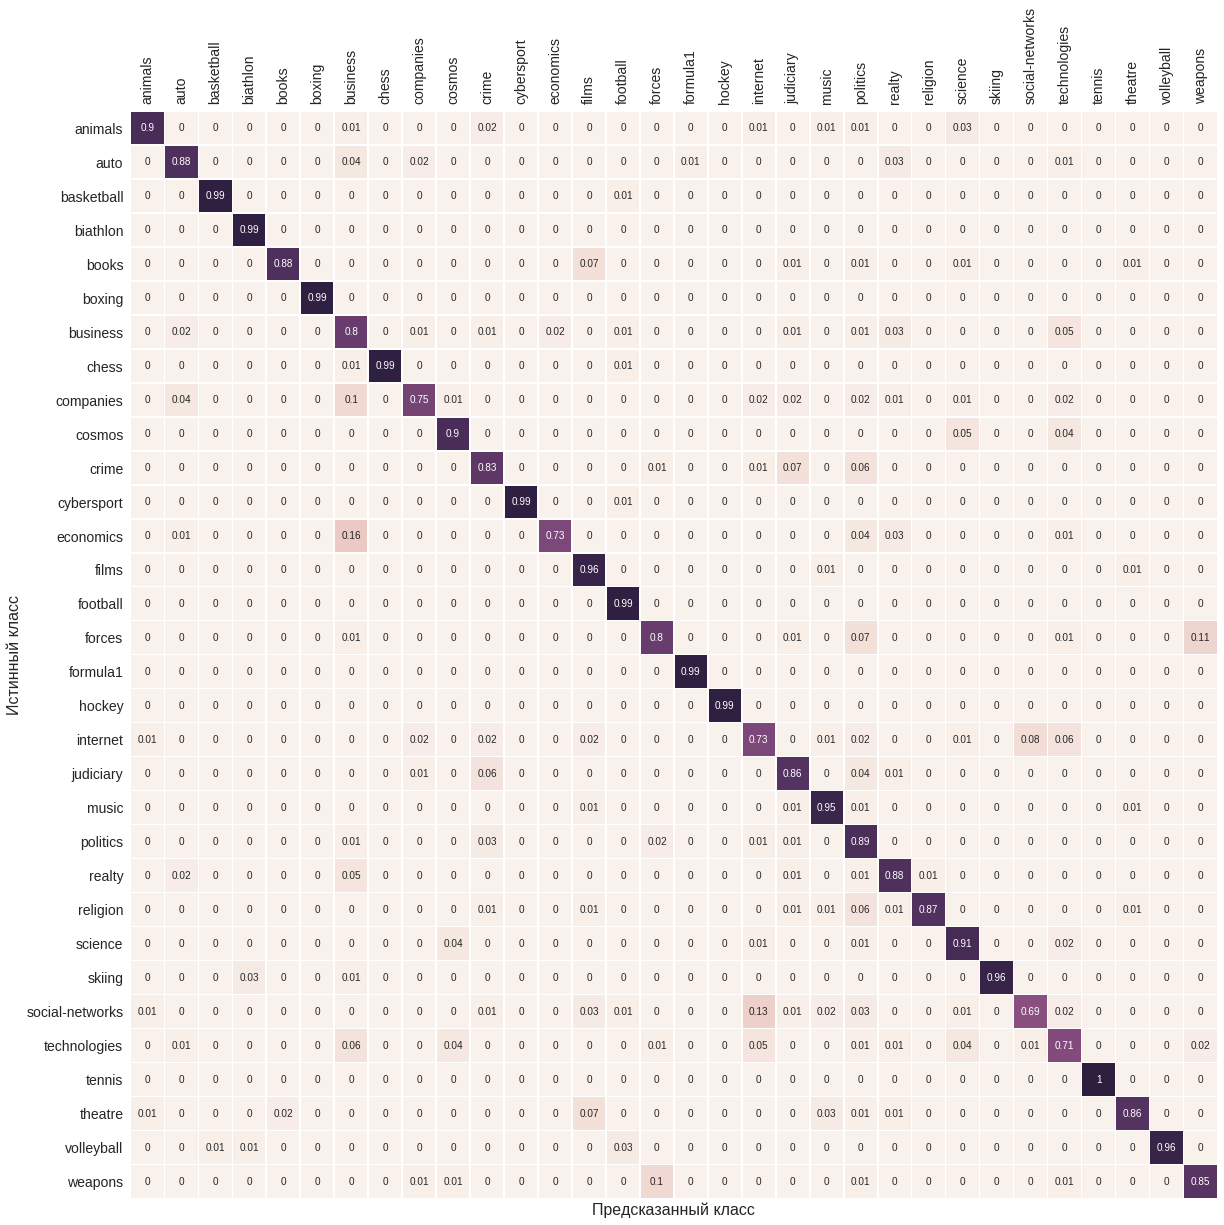

In [55]:
sns.set_context("notebook", font_scale=1.4);
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt='g', cbar=False, square=True, annot_kws={"size": 10});
ax.xaxis.tick_top()
ax.set_xlabel('Предсказанный класс', fontsize=16)
ax.set_ylabel('Истинный класс', fontsize=16)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

In [56]:
class_scores = {}
for i in range(cm_normalized.shape[0]):
    class_scores[classes[i]] = cm_normalized[i,i]

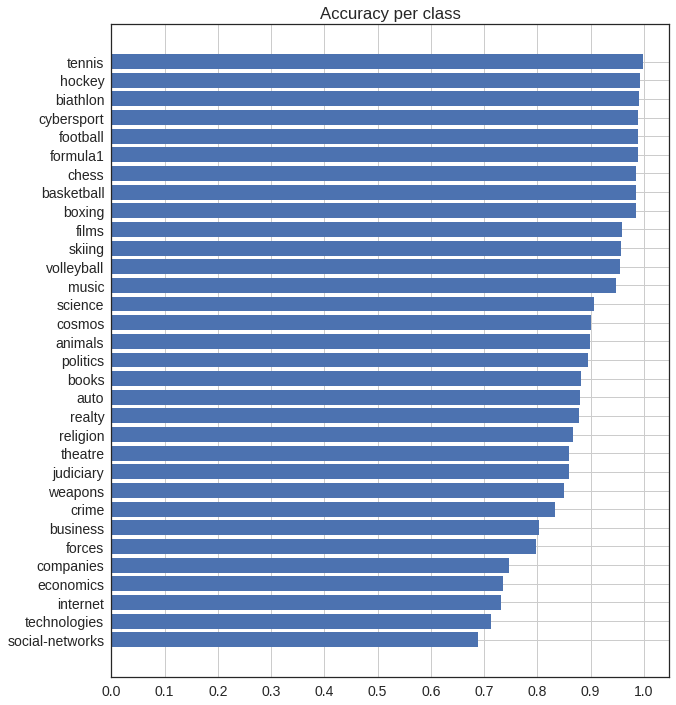

In [59]:
topics = []
scores = []
for topic, score in sorted(class_scores.items(), key=lambda x: x[1]):
    topics.append(topic)
    scores.append(score)
plt.figure(figsize=(10,12))
plt.barh(range(len(topics)), scores)
plt.yticks(range(len(topics)), topics);
plt.xticks(np.arange(0, 1.001, 0.1));
plt.grid(True)
plt.title('Accuracy per class');

### Посмотрим на ошибки классификации

In [ ]:
for i, (true, pred) in enumerate(zip(y_test, clf_prediciton)):
    if true == le.transform(['technologies'])[0] and pred == le.transform(['realty'])[0]:
        print(X_test[i][1])

### Выведем слова с максимальным весом внутри каждого класса

In [60]:
def print_top_K(vectorizer, clf, class_labels, k=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_words = {}
    for i, class_label in enumerate(class_labels):
        top_K = np.argsort(clf.coef_[i])[-k:]
        top_words[class_label] = [feature_names[j] for j in top_K]
    return pd.DataFrame(top_words)

In [63]:
print_top_K(tfidf_vectorizer, clf, le.classes_, k=5)

,animals,auto,basketball,biathlon,books,boxing,business,chess,companies,cosmos,crime,cybersport,economics,films,football,forces,formula1,hockey,internet,judiciary,music,politics,realty,religion,science,skiing,social-networks,technologies,tennis,theatre,volleyball,weapons
0,питомец,камаз,кубок европа,сбр,роман,поединок,fifa,илюмжинов,компания,мкс,изымать,dota,минфин,сериал,фнл,шойгу,рено,нападающий,блогер,обвиняемый,певец,партия,аижк,храм,наука,fis,twitter,wifi,кубок дэвис,мюзикл,суперлига,использоваться
1,животный,автопром,баскетбол,хохфильцен,книга,поветкин,ритейлер,шахматы,процент акция,астронавт,полиция,киберспорт,бюджет,актриса,фифа,военный,пилот,хоккей,ресурс,суд,концерт,парламентарий,ипотека,муфтий,научный,лыжник,пользователь,ростелеком,теннис,постановка,алекно,jane
2,зоопарк,автоваз,баскетболист,биатлон,литературный,бой,formula,карякин,тысяча,спутник,преступник,киберфутбол,экономика,картина,уефа,конашенков,феррари,хоккеист,youtube,следствие,альбом,депутат,жкх,святой,археолог,йохауг,пользователь сеть,мтс,корт,театральный,белогорье,defense
3,кличка,автопроизводитель,евролига,ibu,поэт,бокс,туроператор,шахматный,ретейлер,астрофизик,тюрьма,киберспортивный,ввп,актер,футболист,генштаб,мерседес,нхл,сайт,скр,певица,мид,жилье,митрополит,исследователь,лахти,вконтакте,контакт,теннисист,театр,волейболист,тип
4,животное,автомобиль,нба,биатлонист,писатель,боксер,оао,фид,процент,марс,убивать,киберспортсмен,инфляция,фильм,полузащитник,минобороны,формула,кхл,интернет,комитет россия,музыкант,глава,недвижимость,патриарх,ученый,устюгов,соцсеть,робот,теннисистка,спектакль,волейбол,миллиметровый


# Обучим Word2vec

In [64]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [96]:
corpus = pd.read_csv('./DATA_MANY_TOPICS.csv')[['text', 'topic']]

In [97]:
corpus.text = corpus.text.apply(TEXT_PIPELINE)


  3%|▎         | 6202/188028 [59:52<29:15:13,  1.73it/s]

In [98]:
%%time
min_count = 3
vec_size = 250
window = 5

w2v = Word2Vec([text.split() for text in corpus.text],
               min_count=min_count, size=vec_size, window=window, hs=1, sg=1, workers=8)

2017-05-03 22:31:24,073 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-05-03 22:31:24,074 : INFO : collecting all words and their counts
2017-05-03 22:31:24,075 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-03 22:31:24,265 : INFO : PROGRESS: at sentence #10000, processed 1272552 words, keeping 42273 word types
2017-05-03 22:31:24,481 : INFO : PROGRESS: at sentence #20000, processed 2618710 words, keeping 62008 word types
2017-05-03 22:31:24,721 : INFO : PROGRESS: at sentence #30000, processed 3861867 words, keeping 77694 word types
2017-05-03 22:31:24,925 : INFO : PROGRESS: at sentence #40000, processed 5111744 words, keeping 90938 word types
2017-05-03 22:31:25,139 : INFO : PROGRESS: at sentence #50000, processed 6392161 words, keeping 112325 word types
2017-05-03 22:31:25,369 : INFO : PROGRESS: at sentence #60000, processed 7699467 words, keeping 133414 word types
2017-05-03 22:31:25,623 : INFO : PROGRESS: 

2017-05-03 22:32:23,689 : INFO : PROGRESS: at 3.54% examples, 83236 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:24,859 : INFO : PROGRESS: at 3.60% examples, 82863 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:25,973 : INFO : PROGRESS: at 3.69% examples, 83141 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:26,981 : INFO : PROGRESS: at 3.76% examples, 83030 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:28,044 : INFO : PROGRESS: at 3.82% examples, 82667 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:29,089 : INFO : PROGRESS: at 3.89% examples, 82342 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:30,247 : INFO : PROGRESS: at 3.97% examples, 82378 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:31,344 : INFO : PROGRESS: at 4.05% examples, 82327 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:32,473 : INFO : PROGRESS: at 4.14% examples, 82391 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:32:33,602 : INFO : PROGRESS: at 4.21% examples, 82301 words/s, in_qs

2017-05-03 22:33:52,484 : INFO : PROGRESS: at 9.38% examples, 80118 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:33:53,530 : INFO : PROGRESS: at 9.45% examples, 80145 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:33:54,589 : INFO : PROGRESS: at 9.53% examples, 80166 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:33:55,598 : INFO : PROGRESS: at 9.59% examples, 80146 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:33:56,629 : INFO : PROGRESS: at 9.67% examples, 80180 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:33:57,971 : INFO : PROGRESS: at 9.74% examples, 80039 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:33:59,041 : INFO : PROGRESS: at 9.81% examples, 80054 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:34:00,311 : INFO : PROGRESS: at 9.90% examples, 80026 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:34:01,377 : INFO : PROGRESS: at 9.96% examples, 79978 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:34:02,550 : INFO : PROGRESS: at 10.04% examples, 80004 words/s, in_q

2017-05-03 22:35:19,430 : INFO : PROGRESS: at 17.02% examples, 79666 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:20,631 : INFO : PROGRESS: at 17.17% examples, 79633 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:21,820 : INFO : PROGRESS: at 17.31% examples, 79605 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:22,924 : INFO : PROGRESS: at 17.45% examples, 79606 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:24,017 : INFO : PROGRESS: at 17.63% examples, 79695 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:25,029 : INFO : PROGRESS: at 17.78% examples, 79727 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:26,174 : INFO : PROGRESS: at 17.92% examples, 79713 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:27,451 : INFO : PROGRESS: at 18.06% examples, 79654 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:28,530 : INFO : PROGRESS: at 18.22% examples, 79704 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:35:29,573 : INFO : PROGRESS: at 18.35% examples, 79684 word

2017-05-03 22:36:48,753 : INFO : PROGRESS: at 24.49% examples, 79729 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:49,797 : INFO : PROGRESS: at 24.58% examples, 79773 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:50,890 : INFO : PROGRESS: at 24.66% examples, 79774 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:51,946 : INFO : PROGRESS: at 24.74% examples, 79815 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:53,117 : INFO : PROGRESS: at 24.81% examples, 79795 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:54,132 : INFO : PROGRESS: at 24.88% examples, 79785 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:55,246 : INFO : PROGRESS: at 24.94% examples, 79751 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:56,363 : INFO : PROGRESS: at 25.01% examples, 79716 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:57,487 : INFO : PROGRESS: at 25.09% examples, 79740 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:36:58,579 : INFO : PROGRESS: at 25.16% examples, 79742 word

2017-05-03 22:38:15,888 : INFO : PROGRESS: at 30.21% examples, 79491 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:17,177 : INFO : PROGRESS: at 30.29% examples, 79479 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:18,248 : INFO : PROGRESS: at 30.36% examples, 79485 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:19,383 : INFO : PROGRESS: at 30.43% examples, 79479 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:20,583 : INFO : PROGRESS: at 30.51% examples, 79460 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:21,681 : INFO : PROGRESS: at 30.58% examples, 79461 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:22,694 : INFO : PROGRESS: at 30.66% examples, 79502 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:23,721 : INFO : PROGRESS: at 30.74% examples, 79516 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:24,768 : INFO : PROGRESS: at 30.80% examples, 79503 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:38:25,836 : INFO : PROGRESS: at 30.86% examples, 79462 word

2017-05-03 22:39:44,808 : INFO : PROGRESS: at 38.95% examples, 79458 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:46,109 : INFO : PROGRESS: at 39.11% examples, 79447 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:47,210 : INFO : PROGRESS: at 39.25% examples, 79448 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:48,276 : INFO : PROGRESS: at 39.38% examples, 79454 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:49,284 : INFO : PROGRESS: at 39.53% examples, 79489 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:50,445 : INFO : PROGRESS: at 39.67% examples, 79480 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:51,689 : INFO : PROGRESS: at 39.81% examples, 79457 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:52,739 : INFO : PROGRESS: at 39.94% examples, 79465 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:53,754 : INFO : PROGRESS: at 40.07% examples, 79518 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:39:54,761 : INFO : PROGRESS: at 40.13% examples, 79514 word

2017-05-03 22:41:12,402 : INFO : PROGRESS: at 45.36% examples, 79514 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:13,553 : INFO : PROGRESS: at 45.45% examples, 79525 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:14,687 : INFO : PROGRESS: at 45.51% examples, 79503 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:15,838 : INFO : PROGRESS: at 45.59% examples, 79513 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:17,089 : INFO : PROGRESS: at 45.66% examples, 79493 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:18,123 : INFO : PROGRESS: at 45.73% examples, 79502 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:19,153 : INFO : PROGRESS: at 45.80% examples, 79495 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:20,160 : INFO : PROGRESS: at 45.87% examples, 79508 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:21,234 : INFO : PROGRESS: at 45.95% examples, 79528 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:41:22,284 : INFO : PROGRESS: at 46.02% examples, 79519 word

2017-05-03 22:42:39,697 : INFO : PROGRESS: at 51.07% examples, 79381 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:40,749 : INFO : PROGRESS: at 51.15% examples, 79387 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:41,928 : INFO : PROGRESS: at 51.23% examples, 79393 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:42,996 : INFO : PROGRESS: at 51.30% examples, 79397 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:44,153 : INFO : PROGRESS: at 51.37% examples, 79391 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:45,200 : INFO : PROGRESS: at 51.45% examples, 79397 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:46,255 : INFO : PROGRESS: at 51.51% examples, 79388 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:47,341 : INFO : PROGRESS: at 51.58% examples, 79376 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:48,341 : INFO : PROGRESS: at 51.65% examples, 79388 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:42:49,362 : INFO : PROGRESS: at 51.70% examples, 79369 word

2017-05-03 22:44:07,348 : INFO : PROGRESS: at 60.27% examples, 79443 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:08,433 : INFO : PROGRESS: at 60.35% examples, 79458 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:09,638 : INFO : PROGRESS: at 60.42% examples, 79446 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:10,722 : INFO : PROGRESS: at 60.50% examples, 79447 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:11,897 : INFO : PROGRESS: at 60.58% examples, 79452 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:12,954 : INFO : PROGRESS: at 60.65% examples, 79455 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:14,209 : INFO : PROGRESS: at 60.72% examples, 79439 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:15,247 : INFO : PROGRESS: at 60.79% examples, 79446 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:16,574 : INFO : PROGRESS: at 60.88% examples, 79448 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:44:17,618 : INFO : PROGRESS: at 60.96% examples, 79454 word

2017-05-03 22:45:36,396 : INFO : PROGRESS: at 66.24% examples, 79427 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:37,428 : INFO : PROGRESS: at 66.31% examples, 79434 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:38,658 : INFO : PROGRESS: at 66.40% examples, 79434 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:39,851 : INFO : PROGRESS: at 66.47% examples, 79425 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:41,019 : INFO : PROGRESS: at 66.54% examples, 79419 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:42,031 : INFO : PROGRESS: at 66.61% examples, 79416 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:43,072 : INFO : PROGRESS: at 66.67% examples, 79410 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:44,248 : INFO : PROGRESS: at 66.75% examples, 79415 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:45,289 : INFO : PROGRESS: at 66.83% examples, 79421 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:45:46,365 : INFO : PROGRESS: at 66.89% examples, 79412 word

2017-05-03 22:47:04,195 : INFO : PROGRESS: at 72.00% examples, 79360 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:05,376 : INFO : PROGRESS: at 72.07% examples, 79353 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:06,560 : INFO : PROGRESS: at 72.15% examples, 79357 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:07,745 : INFO : PROGRESS: at 72.23% examples, 79350 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:08,976 : INFO : PROGRESS: at 72.31% examples, 79350 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:10,251 : INFO : PROGRESS: at 72.38% examples, 79335 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:11,424 : INFO : PROGRESS: at 72.46% examples, 79339 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:12,515 : INFO : PROGRESS: at 72.53% examples, 79341 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:13,543 : INFO : PROGRESS: at 72.60% examples, 79337 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:47:14,546 : INFO : PROGRESS: at 72.66% examples, 79335 word

2017-05-03 22:48:32,459 : INFO : PROGRESS: at 81.25% examples, 79403 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:33,495 : INFO : PROGRESS: at 81.33% examples, 79417 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:34,550 : INFO : PROGRESS: at 81.41% examples, 79421 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:35,577 : INFO : PROGRESS: at 81.47% examples, 79418 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:36,611 : INFO : PROGRESS: at 81.53% examples, 79423 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:37,850 : INFO : PROGRESS: at 81.59% examples, 79412 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:38,918 : INFO : PROGRESS: at 81.65% examples, 79405 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:39,942 : INFO : PROGRESS: at 81.71% examples, 79411 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:41,007 : INFO : PROGRESS: at 81.77% examples, 79414 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:48:42,008 : INFO : PROGRESS: at 81.83% examples, 79412 word

2017-05-03 22:49:59,112 : INFO : PROGRESS: at 87.03% examples, 79367 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:00,376 : INFO : PROGRESS: at 87.11% examples, 79364 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:01,475 : INFO : PROGRESS: at 87.17% examples, 79356 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:02,482 : INFO : PROGRESS: at 87.24% examples, 79362 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:03,493 : INFO : PROGRESS: at 87.31% examples, 79361 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:04,615 : INFO : PROGRESS: at 87.38% examples, 79359 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:05,834 : INFO : PROGRESS: at 87.45% examples, 79351 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:06,898 : INFO : PROGRESS: at 87.53% examples, 79362 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:08,028 : INFO : PROGRESS: at 87.60% examples, 79352 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:50:09,105 : INFO : PROGRESS: at 87.67% examples, 79354 word

2017-05-03 22:51:26,268 : INFO : PROGRESS: at 92.71% examples, 79288 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:27,482 : INFO : PROGRESS: at 92.78% examples, 79281 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:28,559 : INFO : PROGRESS: at 92.83% examples, 79282 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:29,588 : INFO : PROGRESS: at 92.88% examples, 79278 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:30,784 : INFO : PROGRESS: at 92.95% examples, 79288 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:32,182 : INFO : PROGRESS: at 93.07% examples, 79277 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:33,414 : INFO : PROGRESS: at 93.23% examples, 79277 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:34,468 : INFO : PROGRESS: at 93.38% examples, 79281 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:35,606 : INFO : PROGRESS: at 93.54% examples, 79287 words/s, in_qsize 15, out_qsize 0
2017-05-03 22:51:36,651 : INFO : PROGRESS: at 93.70% examples, 79299 word

CPU times: user 1h 23min 17s, sys: 8.04 s, total: 1h 23min 25s
Wall time: 21min 3s


In [99]:
word_vectors = w2v.wv
del w2v

### Усредним вектора слов в каждой из новостей с весами tf-idf

In [117]:
word2tfidf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))
vectorized_news = np.zeros((trainX.shape[0], vec_size), dtype="float32")
for i in tqdm(range(trainX.shape[0])):
    words = [word for word in trainX.text.iloc[i].split()
             if word in word_vectors and word in word2tfidf]
    word_vecs = [word_vectors[word] for word in words]
    word_idfs = [word2tfidf[word]  for word in words]
    vectorized_news[i,:] = np.average(word_vecs, axis=0, weights=word_idfs)

100%|██████████| 121529/121529 [00:54<00:00, 2232.35it/s]


In [125]:
trainX_w2v = pd.DataFrame(vectorized_news)

In [126]:
trainX_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,-0.160134,0.353686,0.101597,0.045938,-0.045920,-0.073609,0.186203,0.120424,-0.093335,-0.046091,0.114713,-0.031946,-0.031856,-0.122801,-0.036210,0.112839,-0.109757,-0.143871,-0.275460,-0.046434,0.019823,0.109452,0.032670,-0.050253,-0.008948,0.011508,0.128006,0.043520,-0.022501,-0.035945,-0.043339,-0.303041,-0.068610,-0.017620,-0.183235,-0.196226,0.059970,-0.017655,0.059593,0.143266,0.075829,-0.012707,0.091569,-0.073111,-0.057575,-0.066141,-0.044065,0.086979,-0.139073,0.113423,0.236593,-0.169040,0.091834,0.080459,-0.003892,0.081389,-0.058326,0.074962,0.264564,0.043686,0.192285,-0.075431,0.018149,-0.088487,-0.198483,0.207563,-0.097258,0.145735,-0.031355,-0.041317,0.129523,-0.113719,-0.012885,-0.022651,0.142723,-0.070345,0.043245,-0.022169,0.104583,0.011995,-0.146156,0.095228,-0.000170,0.071624,-0.226672,0.144932,0.055947,-0.049063,0.032521,0.184466,0.075979,0.076590,0.042101,-0.044160,-0.005681,0.013268,0.071818,-0.064595,0.048432,-0.139247,0.048855,0.102576,-0.134049,0.082925,0.126085,-0.064532,-0.073327,-0.130254,-0.014918,-0.061385,0.083011,-0.004024,0.142479,-0.068043,-0.035854,0.158728,-0.068686,-0.001591,-0.121797,0.020370,0.087908,0.026013,0.018525,-0.226682,0.065699,-0.139623,-0.082362,-0.034240,-0.087022,-0.058600,-0.108449,0.010117,-0.067337,-0.070616,0.036361,0.012856,-0.000469,-0.140944,0.112511,0.164784,-0.127047,0.201584,-0.039956,-0.033295,0.003880,0.062005,0.158827,-0.032883,-0.166077,0.056536,-0.057749,0.057565,0.076026,-0.019689,-0.044495,-0.147359,-0.053066,0.092497,-0.038444,0.126450,-0.015177,0.019241,-0.024606,-0.057624,-0.042051,-0.142970,-0.023717,0.152789,0.021025,0.025612,0.088225,0.055333,0.121386,-0.022483,-0.025824,-0.043190,0.097721,0.043889,-0.014778,-0.022129,-0.043706,-0.137917,-0.101740,0.050112,0.012365,-0.004215,-0.116422,-0.086153,0.053150,-0.284410,0.060065,0.057246,-0.008426,-0.077512,0.089921,0.019299,-0.129892,-0.061319,-0.099105,0.044290,-0.020101,-0.155909,0.064235,0.061359,0.121257,0.007407,-0.085233,-0.107081,-0.034246,0.012697,-0.147632,-0.120763,-0.112967,0.029663,0.062771,0.064344,0.085555,-0.072925,0.000295,-0.110732,0.034806,-0.065177,0.122920,0.016716,0.069151,-0.110882,0.058196,-0.025207,-0.170466,0.016976,-0.137805,0.029061,-0.084019,-0.095109,-0.049598,0.068048,0.151308,0.086508,-0.015125,0.013624,0.086696,0.010941,-0.111296,-0.031179,-0.071112,0.237018,0.022217,0.001530,-0.077370,0.047305
1,-0.153905,0.307571,0.215715,0.180340,0.002409,-0.014575,0.222212,0.001236,-0.047686,0.120764,0.176276,-0.055308,-0.111837,-0.182067,-0.060095,0.186498,-0.005290,-0.087668,-0.221026,-0.087669,-0.052447,0.032070,0.002514,-0.163866,0.074325,0.077478,0.197692,0.003720,-0.037734,-0.023414,-0.153640,-0.185116,-0.078398,0.053212,-0.105777,-0.140740,0.020900,-0.069051,0.067634,-0.018107,0.001326,-0.039435,0.046122,-0.020138,-0.012550,-0.008884,0.007180,0.159084,-0.133129,0.077431,0.280924,-0.077507,0.142385,0.104942,0.036617,0.132842,-0.076445,0.127705,0.246024,0.005590,0.121848,-0.112993,0.117305,0.012986,0.033054,0.236264,-0.120734,0.044645,0.022579,-0.021699,0.103410,-0.157979,-0.078455,-0.140948,0.179591,-0.141187,-0.

In [122]:
# trainX_w2v.to_csv('./trainX_w2v.csv')

In [127]:
trainX_w2v.shape, trainY.shape

((121529, 250), (121529,))

# Получим распределение топиков с помощью BigARTM

In [ ]:
import warnings
warnings.simplefilter('ignore')
import artm

### Удалим слова, встречающиеся только один раз

In [77]:
corpus.text = corpus.text.apply(lambda x: ' '.join([w for w in str(x).split() if vocabulary[w] > 1]))

### Создадим файл в формате vowpal wabbit

In [80]:
vw_file_name = 'news_for_bigartm.vw'
with open(vw_file_name, 'w') as file:
    for i, doc in enumerate(corpus.text):
        print('doc{} {}'.format(i+1, doc), file=file)

### Создадим батчи для обучения и загрузим их в словарь bigARTM

In [83]:
batch_vectorizer = artm.BatchVectorizer(data_path=vw_file_name, data_format='vowpal_wabbit',
                                        target_folder='./bigartm_batches')

In [84]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='./bigartm_batches')

### Инициализируем ARTM модель.
Добавим к ней регуляризаторы декорреляции и разреженности для матриц $\Theta$ и $\Phi$. 

In [87]:
%%time
model = artm.ARTM(num_topics=300, dictionary=dictionary, cache_theta=True, show_progress_bars=True)

model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.2))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2e5))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothSparseThetaRegularizer', tau=-0.001))

model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top_tokens_score', dictionary=dictionary))
model.num_tokens = 10 # макс. число токенов для отображения

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)


In [86]:
saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens
for topic, top_tokens in saved_top_tokens.items():
    print(topic, *top_tokens)

topic_69 телеканал канал эфир обмен телевидение дождь cnn спутниковый fox nbc
topic_271 аэропорт борт экипаж терминал лайнер вылет вылетать воздушный полет крушение
topic_13 сопротивление мишель сокол дизель андреас карл благоустройство бирюк терминатор рэй
topic_256 организация бывший август руководитель управление заниматься деятельность заместитель имущество начальник
topic_38 среда клиент установленный возобновлять энергетический электроэнергия энергия филиал альтернативный экологический
topic_91 университет элемент эксперимент свет частица ученый физик теория квантовый описывать
topic_261 список попадать включать въезд перечень замораживать фамилия включение латвия волна
topic_19 нижний запад справедливый лишать вячеслав кпрф лдпр спикер новгород сессия
topic_99 задача отдельный боевой выполнение учение приступать готовность оперативный противник бригада
topic_182 слово отмечать принимать должный проводить начинать приводить некоторые напоминать очередь
topic_121 победа поражение 

In [88]:
def create_batch(documents, vocab):
    ''' Creates bath from list of documents 
        :param: documents - list of documents represented as string,
            eg. ['Hello world!', 'How are you? - I am fine, thanks!']
        
        :param: vocab - dict of term frequencies
        
        :return: bigARTM batch
    '''
    
    import uuid
    from collections import defaultdict
    
    batch = artm.messages.Batch()
    batch.id = str(uuid.uuid4())
    dictionary = {}

    # first step: fill the general batch vocabulary
    for i, token in enumerate(vocab):
        batch.token.append(token)
        dictionary[token] = i

    # second step: fill the items
    for doc in documents:
        item = batch.item.add()    
        local_dict = defaultdict(int)
        for token in doc.split():
            local_dict[token] += 1
        for k, v in local_dict.items():
            if k in dictionary:
                item.token_id.append(dictionary[k])
                item.token_weight.append(v)
    return batch

In [93]:
batch = create_batch(trainX.text.values, vocabulary)
bigartm_feats = model.master.transform(batches=[batch])[1]
top_cols = sorted(saved_top_tokens.keys(), key=lambda x: int(x.split('_')[1]))

In [131]:
# pd.DataFrame(bigartm_feats, columns=top_cols).to_csv('data_bigartm_feats.csv')
trainX_bigartm = pd.DataFrame(bigartm_feats, columns=top_cols)

# Обучим градиентный бустинг (LightGBM)

In [142]:
import lightgbm as lgb
import warnings
warnings.simplefilter('ignore')

In [160]:
X_train, X_test, y_train, y_test = train_test_split(pd.concat([trainX_w2v, trainX_bigartm], axis=1).values, trainY.values, test_size=0.3,
                                                    stratify=trainY.values, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test)

In [161]:
X_train.shape

(85070, 550)

In [167]:
lgb_param = {
    'colsample_bytree': 0.9,
    'is_unbalance': False,
    'learning_rate': 0.01,
    'max_bin': 255,
    'max_depth': 7,
    'min_child_samples': 10,
    'min_child_weight': 5,
    'min_split_gain': 0,
    'nthread': 4,
    'num_leaves': 511,
    'objective': 'multiclass',
    'metric': 'multi_error',
    'is_training_metric': True,
    'num_class': len(le.classes_),
    'reg_alpha': 0,
    'reg_lambda': 0,
    'silent': True,
    'subsample': 0.8,
}

In [ ]:
%%time
clf = lgb.train(lgb_param, lgb_train, num_boost_round=10000, valid_sets=[lgb_valid],
            early_stopping_rounds=150, verbose_eval=25)

Train until valid scores didn't improve in 150 rounds.
[25]	valid_0's multi_error: 0.190625
[50]	valid_0's multi_error: 0.183274
[75]	valid_0's multi_error: 0.179078
[100]	valid_0's multi_error: 0.176253
[125]	valid_0's multi_error: 0.173894
[150]	valid_0's multi_error: 0.171453
[175]	valid_0's multi_error: 0.169423
[200]	valid_0's multi_error: 0.168024
[225]	valid_0's multi_error: 0.166296
[250]	valid_0's multi_error: 0.16498
[275]	valid_0's multi_error: 0.163334
[300]	valid_0's multi_error: 0.162566
[325]	valid_0's multi_error: 0.161798
[350]	valid_0's multi_error: 0.160811
[375]	valid_0's multi_error: 0.159714
[400]	valid_0's multi_error: 0.158754
[425]	valid_0's multi_error: 0.157876
[450]	valid_0's multi_error: 0.157602
[475]	valid_0's multi_error: 0.156779


In [172]:
# clf_prediciton = clf.predict(X_test).argmax(axis=1)
print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, clf_prediciton))

# w2v only:
# F1 score: 0.848992506048
# Accuracy: 0.8401492087

# bigARTM only:
# F1 score: 0.841717418846
# Accuracy: 0.835952714008

# bigARTM + w2v:
F1 score: 0.872151892589
Accuracy: 0.864093913711

F1 score: 0.872151892589
Accuracy: 0.864093913711
